
# Clustering text documents using k-means

Source: https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

This is an example showing how the scikit-learn API can be used to cluster
documents by topics using a [Bag of Words approach](https://en.wikipedia.org/wiki/Bag-of-words_model).

Two algorithms are demonstrated, namely :class:`~sklearn.cluster.KMeans` and its more
scalable variant, :class:`~sklearn.cluster.MiniBatchKMeans`. Additionally,
latent semantic analysis is used to reduce dimensionality and discover latent
patterns in the data.

This example uses two different text vectorizers: a
:class:`~sklearn.feature_extraction.text.TfidfVectorizer` and a
:class:`~sklearn.feature_extraction.text.HashingVectorizer`. See the example
notebook `sphx_glr_auto_examples_text_plot_hashing_vs_dict_vectorizer.py`
for more information on vectorizers and a comparison of their processing times.

For document analysis via a supervised learning approach, see the example script
`sphx_glr_auto_examples_text_plot_document_classification_20newsgroups.py`.


In [1]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Lars Buitinck
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Arturo Amor <david-arturo.amor-quiroz@inria.fr>
# License: BSD 3 clause

## Loading text data

We load data from `20newsgroups_dataset`, which comprises around 18,000
newsgroups posts on 20 topics. For illustrative purposes and to reduce the
computational cost, we select a subset of 4 topics only accounting for around
3,400 documents. See the example
`sphx_glr_auto_examples_text_plot_document_classification_20newsgroups.py`
to gain intuition on the overlap of such topics.

Notice that, by default, the text samples contain some message metadata such
as `"headers"`, `"footers"` (signatures) and `"quotes"` to other posts. We use
the `remove` parameter from :func:`~sklearn.datasets.fetch_20newsgroups` to
strip those features and have a more sensible clustering problem.



In [2]:
import numpy as np

from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(dataset.data)} documents - {true_k} categories")

3387 documents - 4 categories


## Quantifying the quality of clustering results

From (https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html)

In this section we define a function to score different clustering pipelines
using several metrics.

Clustering algorithms are fundamentally unsupervised learning methods.
However, since we happen to have class labels for this specific dataset, it is
possible to use evaluation metrics that leverage this "supervised" ground
truth information to quantify the quality of the resulting clusters. Examples
of such metrics are the following:

- homogeneity, which quantifies how much clusters contain only members of a
  single class;

- completeness, which quantifies how much members of a given class are
  assigned to the same clusters;

- V-measure, the harmonic mean of completeness and homogeneity;

- Rand-Index, which measures how frequently pairs of data points are grouped
  consistently according to the result of the clustering algorithm and the
  ground truth class assignment;

- Adjusted Rand-Index, a chance-adjusted Rand-Index such that random cluster
  assignment have an ARI of 0.0 in expectation.

If the ground truth labels are not known, evaluation can only be performed
using the model results itself. In that case, the Silhouette Coefficient comes in
handy. See `sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`
for an example on how to do it.

For more reference, see `clustering_evaluation`.



In [3]:
from collections import defaultdict
from time import time

from sklearn import metrics

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

## K-means clustering on text features

Two feature extraction methods are used in this example:

- :class:`~sklearn.feature_extraction.text.TfidfVectorizer` uses an in-memory
  vocabulary (a Python dict) to map the most frequent words to features
  indices and hence compute a word occurrence frequency (sparse) matrix. The
  word frequencies are then reweighted using the Inverse Document Frequency
  (IDF) vector collected feature-wise over the corpus.

- :class:`~sklearn.feature_extraction.text.HashingVectorizer` hashes word
  occurrences to a fixed dimensional space, possibly with collisions. The word
  count vectors are then normalized to each have l2-norm equal to one
  (projected to the euclidean unit-sphere) which seems to be important for
  k-means to work in high dimensional space.

Furthermore it is possible to post-process those extracted features using
dimensionality reduction. We will explore the impact of those choices on the
clustering quality in the following.

### Feature Extraction using TfidfVectorizer

We first benchmark the estimators using a dictionary vectorizer along with an
IDF normalization as provided by
:class:`~sklearn.feature_extraction.text.TfidfVectorizer`.



In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(dataset.data)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 2.713 s
n_samples: 3387, n_features: 7929


After ignoring terms that appear in more than 50% of the documents (as set by
`max_df=0.5`) and terms that are not present in at least 5 documents (set by
`min_df=5`), the resulting number of unique terms `n_features` is around
8,000. We can additionally quantify the sparsity of the `X_tfidf` matrix as
the fraction of non-zero entries divided by the total number of elements.



In [5]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

0.007


We find that around 0.7% of the entries of the `X_tfidf` matrix are non-zero.


### Clustering sparse data with k-means

As both :class:`~sklearn.cluster.KMeans` and
:class:`~sklearn.cluster.MiniBatchKMeans` optimize a non-convex objective
function, their clustering is not guaranteed to be optimal for a given random
init. Even further, on sparse high-dimensional data such as text vectorized
using the Bag of Words approach, k-means can initialize centroids on extremely
isolated data points. Those data points can stay their own centroids all
along.

The following code illustrates how the previous phenomenon can sometimes lead
to highly imbalanced clusters, depending on the random initialization:



In [6]:
from sklearn.cluster import KMeans

for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}")
print()
print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes}"
)

Number of elements assigned to each cluster: [   1    1 3384    1]
Number of elements assigned to each cluster: [1688  725  238  736]
Number of elements assigned to each cluster: [2004  446  646  291]
Number of elements assigned to each cluster: [1695  649  446  597]
Number of elements assigned to each cluster: [ 338 2155  417  477]

True number of documents in each category according to the class labels: [799 973 987 628]


To avoid this problem, one possibility is to increase the number of runs with
independent random initiations `n_init`. In such case the clustering with the
best inertia (objective function of k-means) is chosen.



In [7]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5,
)

fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")

clustering done in 6.40 ± 1.39 s 
Homogeneity: 0.343 ± 0.029
Completeness: 0.404 ± 0.009
V-measure: 0.370 ± 0.018
Adjusted Rand-Index: 0.213 ± 0.012
Silhouette Coefficient: 0.008 ± 0.001


All those clustering evaluation metrics have a maximum value of 1.0 (for a
perfect clustering result). Higher values are better. Values of the Adjusted
Rand-Index close to 0.0 correspond to a random labeling. Notice from the
scores above that the cluster assignment is indeed well above chance level,
but the overall quality can certainly improve.

Keep in mind that the class labels may not reflect accurately the document
topics and therefore metrics that use labels are not necessarily the best to
evaluate the quality of our clustering pipeline.

### Performing dimensionality reduction using LSA

A `n_init=1` can still be used as long as the dimension of the vectorized
space is reduced first to make k-means more stable. For such purpose we use
:class:`~sklearn.decomposition.TruncatedSVD`, which works on term count/tf-idf
matrices. Since SVD results are not normalized, we redo the normalization to
improve the :class:`~sklearn.cluster.KMeans` result. Using SVD to reduce the
dimensionality of TF-IDF document vectors is often known as [latent semantic
analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis) (LSA) in
the information retrieval and text mining literature.



In [8]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 1.756 s
Explained variance of the SVD step: 18.4%


Using a single initialization means the processing time will be reduced for
both :class:`~sklearn.cluster.KMeans` and
:class:`~sklearn.cluster.MiniBatchKMeans`.



In [9]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 0.09 ± 0.03 s 
Homogeneity: 0.394 ± 0.014
Completeness: 0.435 ± 0.013
V-measure: 0.413 ± 0.012
Adjusted Rand-Index: 0.324 ± 0.016
Silhouette Coefficient: 0.032 ± 0.002


### Top terms per cluster

Since :class:`~sklearn.feature_extraction.text.TfidfVectorizer` can be
inverted we can identify the cluster centers, which provide an intuition of
the most influential words **for each cluster**. See the example script
`sphx_glr_auto_examples_text_plot_document_classification_20newsgroups.py`
for a comparison with the most predictive words **for each target class**.



In [11]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: just think don know like time say ve good does 
Cluster 1: god people jesus bible believe don think say christian religion 
Cluster 2: space launch orbit nasa moon shuttle earth like mission satellite 
Cluster 3: graphics thanks image program files file know looking help format 


### HashingVectorizer
An alternative vectorization can be done using a
:class:`~sklearn.feature_extraction.text.HashingVectorizer` instance, which
does not provide IDF weighting as this is a stateless model (the fit method
does nothing). When IDF weighting is needed it can be added by pipelining the
:class:`~sklearn.feature_extraction.text.HashingVectorizer` output to a
:class:`~sklearn.feature_extraction.text.TfidfTransformer` instance. In this
case we also add LSA to the pipeline to reduce the dimension and sparcity of
the hashed vector space.



In [12]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer

lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(dataset.data)
print(f"vectorization done in {time() - t0:.3f} s")

vectorization done in 5.194 s


One can observe that the LSA step takes a relatively long time to fit,
especially with hashed vectors. The reason is that a hashed space is typically
large (set to `n_features=50_000` in this example). One can try lowering the
number of features at the expense of having a larger fraction of features with
hash collisions as shown in the example notebook
`sphx_glr_auto_examples_text_plot_hashing_vs_dict_vectorizer.py`.

We now fit and evaluate the `kmeans` and `minibatch_kmeans` instances on this
hashed-lsa-reduced data:



In [13]:
fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans\nwith LSA on hashed vectors")

clustering done in 0.11 ± 0.04 s 
Homogeneity: 0.393 ± 0.015
Completeness: 0.442 ± 0.018
V-measure: 0.416 ± 0.016
Adjusted Rand-Index: 0.331 ± 0.010
Silhouette Coefficient: 0.030 ± 0.001


Both methods lead to good results that are similar to running the same models
on the traditional LSA vectors (without hashing).

## Clustering evaluation summary



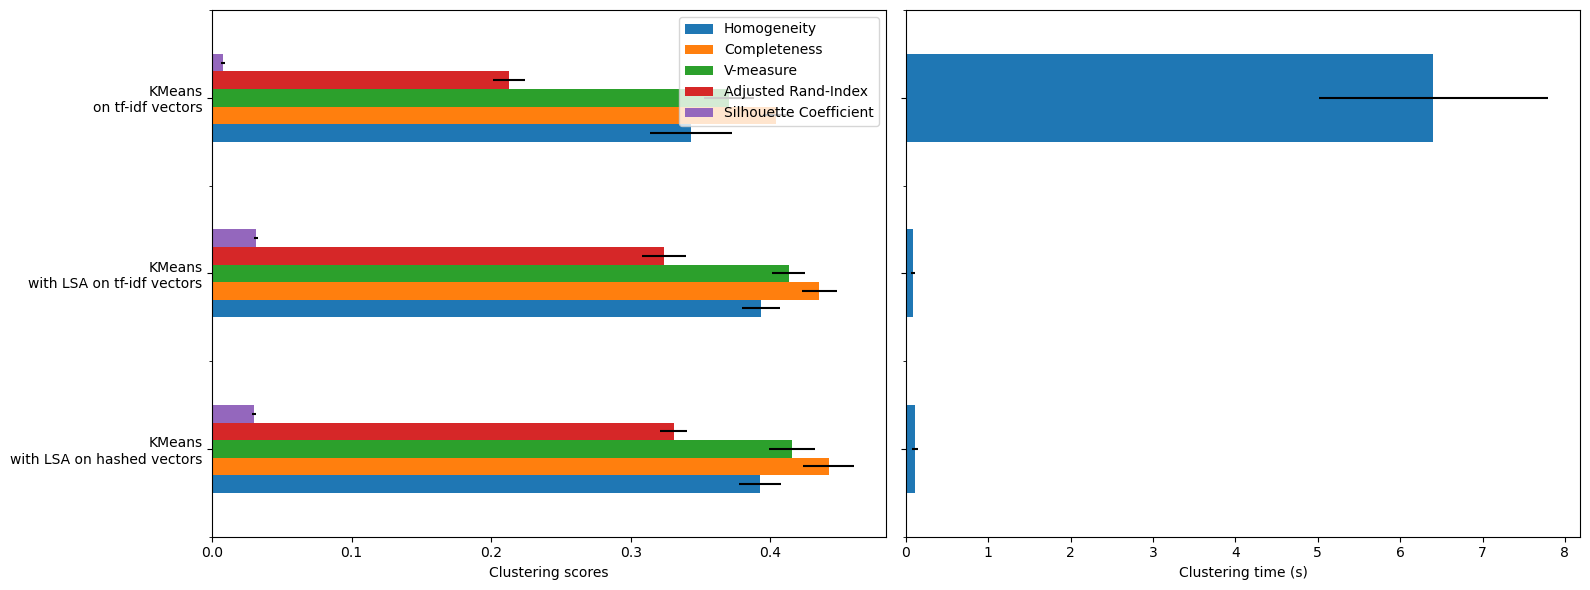

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()

:class:`~sklearn.cluster.KMeans` and :class:`~sklearn.cluster.MiniBatchKMeans`
suffer from the phenomenon called the [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) for high dimensional
datasets such as text data. That is the reason why the overall scores improve
when using LSA. Using LSA reduced data also improves the stability and
requires lower clustering time, though keep in mind that the LSA step itself
takes a long time, especially with hashed vectors.

The Silhouette Coefficient is defined between 0 and 1. In all cases we obtain
values close to 0 (even if they improve a bit after using LSA) because its
definition requires measuring distances, in contrast with other evaluation
metrics such as the V-measure and the Adjusted Rand Index which are only based
on cluster assignments rather than distances. Notice that strictly speaking,
one should not compare the Silhouette Coefficient between spaces of different
dimension, due to the different notions of distance they imply.

The homogeneity, completeness and hence v-measure metrics do not yield a
baseline with regards to random labeling: this means that depending on the
number of samples, clusters and ground truth classes, a completely random
labeling will not always yield the same values. In particular random labeling
won't yield zero scores, especially when the number of clusters is large. This
problem can safely be ignored when the number of samples is more than a
thousand and the number of clusters is less than 10, which is the case of the
present example. For smaller sample sizes or larger number of clusters it is
safer to use an adjusted index such as the Adjusted Rand Index (ARI). See the
example
`sphx_glr_auto_examples_cluster_plot_adjusted_for_chance_measures.py` for
a demo on the effect of random labeling.

The size of the error bars show that :class:`~sklearn.cluster.MiniBatchKMeans`
is less stable than :class:`~sklearn.cluster.KMeans` for this relatively small
dataset. It is more interesting to use when the number of samples is much
bigger, but it can come at the expense of a small degradation in clustering
quality compared to the traditional k-means algorithm.



# AntClust Cosine Similarity

Apply AntClust for text data and compare with previous results

In [35]:
# ----------------------
#       imports
# ----------------------
# import opencv
import cv2 as cv
# matplotlib
import matplotlib.pyplot as plt

# make AntClus dir known
import sys
sys.path.append("../AntClust")
# import AntClust
from AntClust import AntClust
from importlib import reload

# import the precomputed distance matrix function for AntClust
import distance_classes
reload(distance_classes)# import the rule set
from rules import labroche_rules

# ----------------------
#       AntClust
# ----------------------
# tell AntClust to treat the data set as precomputed similarity matrix
# similarity function
f_sim = [distance_classes.text_cosine_similarity(dataset.data)]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

In [36]:
# ----------------------
#       AntClust
# ----------------------
# tell AntClust to treat the data set as precomputed similarity matrix
# similarity function
ant_clust = AntClust(f_sim, labroche_rules())
t0 = time()
# find clusters by using the distance matrix of the data
ant_clust.fit([[i] for i in range(len(dataset.data))])
train_time = time() - t0
# get the clustering result
clusters_found = ant_clust.get_clusters()

AntClust: phase 1 of 3 -> meeting ants
Meeting 254025 / 254025
Meeting 203220 / 254025
Meeting 152415 / 254025
Meeting 101610 / 254025
Meeting 50805 / 254025
AntClust: phase 2 of 3 -> shrink nests
AntClust: phase 3 of 3 -> reassign ants


In [53]:
name = "AntClust\n Cosine Similarity"
scores = defaultdict(list)
homogeneity_score = metrics.homogeneity_score(labels, clusters_found)
completeness_score = metrics.completeness_score(labels, clusters_found)
v_score = metrics.v_measure_score(labels, clusters_found)
ari_score = metrics.adjusted_rand_score(labels, clusters_found)

print(f"clustering done in {train_time:.2f} s ")
print(f"Homogeneity: {homogeneity_score}")
print(f"Completeness: {completeness_score}")
print(f"V-measure: {v_score}")
print(f"Adjusted Rand-Index: {ari_score}")



ValueError: Expected 2D array, got 1D array instead:
array=["My point is that you set up your views as the only way to believe.  Saying \nthat all eveil in this world is caused by atheism is ridiculous and \ncounterproductive to dialogue in this newsgroups.  I see in your posts a \nspirit of condemnation of the atheists in this newsgroup bacause they don'\nt believe exactly as you do.  If you're here to try to convert the atheists \nhere, you're failing miserably.  Who wants to be in position of constantly \ndefending themselves agaist insulting attacks, like you seem to like to do?!\nI'm sorry you're so blind that you didn't get the messgae in the quote, \neveryone else has seemed to."
 "\nBy '8 grey level images' you mean 8 items of 1bit images?\nIt does work(!), but it doesn't work if you have more than 1bit\nin your screen and if the screen intensity is non-linear.\n\nWith 2 bit per pixel; there could be 1*c_1 + 4*c_2 timing,\nthis gives 16 levels, but they are linear if screen intensity is\nlinear.\nWith 1*c_1 + 2*c_2 it works, but we have to find the best\ncompinations -- there's 10 levels, but 16 choises; best 10 must be\nchosen. Different compinations for the same level, varies a bit, but\nthe levels keeps their order.\n\nReaders should verify what I wrote... :-)"
 'FIRST ANNUAL PHIGS USER GROUP CONFERENCE\n\n          The First Annual PHIGS User Group Conference was held March 21-24\n          in Orlando, Florida.  The conference was organized by the Rensse-\n          laer Design Research Center in co-operation with  IEEE  and  SIG-\n          GRAPH.   Attendees  came  from five countries spanning three con-\n          tinents.   A  good  cross-section  of  the  PHIGS  community  was\n          represented  at this conference with participants including PHIGS\n          users, workstation vendors, third-party PHIGS implementors, stan-\n          dards  committee  members,  and  researchers  from  industry  and\n          academia.  The opening speaker, Dr. Richard Puk, challenged PHIGS\n          users  to  "take  charge of your PHIGS" by participating in PHIGS\n          standardization activities and communicating their needs to PHIGS\n          implementors.    The   closing  speaker,  Dr.  Andries  Van  Dam,\n          described his vision of the future of graphics standards  "beyond\n          PHIGS".\n\n          Technical paper sessions in the conference covered the  following\n          topics:  PHIGS  and  X, Application Toolkits, Application Issues,\n          Texture Mapping, NURBS,  PHIGS  Extensions,  and  Object-Oriented\n          Libraries and Frameworks.  Panel sessions on PHIGS and PEX, PHIGS\n          Non-Retained Data, Real-World CAD Applications Using  PHIGS,  and\n          Portability  Issues generated enthusiastic discussions and formed\n          a good forum for exchange of ideas, needs, and experiences.   The\n          conference  also included a day full of tutorials on topics rang-\n          ing from mathematics for 3D  graphics  to  object-oriented  tools\n          based on PHIGS.\n\n          Next year\'s conference is planned for March, 1994.\n\n          PHIGS EVERYWHERE\n\n          At the conference, PHIGS  vendors   described   and  demonstrated\n          PHIGS  products  that  run on all types of computers, from PCs to\n          mainframes.\n\n          Megatek Corporation demonstrated their PHIGS extensions including\n          conditional traversal, composite logical input devices, texturing\n          and translucency.\n\n          Template Graphics  Software  launched  FIGARO+  PRO,  the  Photo-\n          Realistic  Option  for  PHIGS+.  FIGARO+  PRO  is designed to add\n          advanced rendering to the existing PHIGS+ API, with features like\n          ray   tracing,  materials,  anti-aliasing  and  texture  mapping.\n          Radiosity support is also planned.\n\n          FIGARO+ is an example of how TGS continues to add newly  emerging\n          graphics  features to their products.  FIGARO+ supports immediate\n          mode extensions to PHIGS and also supports SUN XGL,  HP  Starbase\n          and SGI GL/OpenGL. FIGARO+ for NT will be released this summer.\n\n          TGS also demonstrated the latest versions of FIGraph, a  powerful\n          "2-call"  charting  system  based on PHIGS+, and FIGt, an object-\n          oriented utility library for PHIGS/PEX developers.\n\n          G5G and Gallium Software demonstrated a new version of GPHIGS  on\n          Silicon  Graphics  workstations. Scheduled for summer, 1993, Ver-\n          sion 3.0 of GPHIGS, the company\'s  PHIGS+  library  for  worksta-\n          tions,  will include an advanced PHIGS debugger that allows PHIGS\n          developers to display and browse PHIGS structures and other PHIGS\n          internal  state.  G5G  also  described  their Non-Duplicated Data\n          Store that stores pointers to application data in the GPHIGS  CSS\n          for  more  efficient  use  of  memory. In addition, G5G described\n          their application GSE that allows application callback  functions\n          during  GPHIGS traversal.  GPHIGS and PHIGURE, G5G\'s data visual-\n          izer and application development toolkit, are currently available\n          on  all  major  workstations  that support GL, X Windows, PEX, or\n          Starbase.\n\n          Wise Software presented a slide show of  Z-PHIGS  for  MS-Windows\n          and ARENA, a PHIGS based modeller/render. Z-PHIGS implements most\n          of the PHIGS+ primitives.  In addition Z-PHIGS has built in  many\n          advanced  rendering features like texture mapping, shadow genera-\n          tion, area quick updates and ray tracing. A demo disk of  Z-PHIGS\n          or ARENA is available on request.\n\n          ATC exhibited GRAFPAK-PHIGS, their full-featured PHIGS  implemen-\n          tation  based  on  DEC  PHIGS. GRAFPAK-PHIGS is available on most\n          workstation platforms with C, FORTRAN and Ada bindings and incor-\n          porates PEX support.\n\n          Within the booth sponsored by Advanced Technology Center, Digital\n          Equipment  Corporation demonstrated DEC PHIGS V2.4 running on the\n          DEC 3000/400 AXP PXG. ATCs\' GRAFPAK-PHIGS is a port of DEC PHIGS.\n          DEC  PHIGS  V2.4 contains most PHIGS and PHIGS PLUS features with\n          support for PEX V5.1  protocol.  DEC  PHIGS  also  contains  most\n          GM/EDS   PHIGS  extensions  including  post-to-view  as  well  as\n          proprietary extensions to support immediate  mode  rendering  and\n          the use of PHIGS in an X11 environment.\n\n          AXP, DEC, and DEC PHIGS are trademarks of Digital Equipment  Cor-\n          poration.  GRAFPAK-PHIGS and ATC are trademarks of Advanced Tech-\n          nology Center. PEX and X11 are trademarks of Massachusetts Insti-\n          tute of Technology.\n\n          The IBM exhibit featured a GTO accelerator attached to an IBM 340\n          workstation running graPHIGS and PEX.\n\n          Hewlett Packard and SHOgraphics demonstrated at the conference. A\n          Hewlett  Packard  machine was coupled to display on a SHOgraphics\n          PEX terminal. HP showcased their latest  PHIGS  product  enhance-\n          ments.\n\n\n          PHIGS USER GROUP\n\n          The PHIGS Users Group was formed to aid the development of  PHIGS\n          applications  and provide user feedback to PHIGS implementors and\n          PHIGS standards bodies.  For more  information  about  the  PHIGS\n          Users Group, send e-mail to:\n\n                    phigsug@cadrt10.me.vt.edu\n\n          or write to:\n\n                    Sankar Jayaram\n                    Virginia Polytechnic Institute\n                    114 Randolph Hall\n                    Blacksburg, Va. 24061-0238\n                    FAX: 703-231-9100\n\n\n          VENDOR CONTACTS\n\n          Megatek Corporation\n          TEL (619) 455-5590\n          FAX (619) 453-7603\n\n          Template Graphics Software\n          TEL (800) 544-4847\n          FAX (619) 452-2547\n\n          WISE software GmbH\n          TEL +49-451-3909-413\n          FAX +49-451-3909-499\n\n          G5G - North American Sales\n          TEL (800) 267-2626\n          FAX (613) 592-1278\n\n          Advanced Technology Center\n          TEL (800) 999-5711\n          FAX (714) 583-9213\n\n          Digital Equipment Corporation\n          TEL (603) 884-5111\n\n          International Business Machines Corporation\n          TEL (800) 426-3333\n\n          Hewlett Packard Company\n          TEL (303) 229-3800\n\n          COPIES OF THE CONFERENCE PROCEEDINGS\n\n          Copies of the conference proceedings may be obtained by  contact-\n          ing Mary Johnson at:\n\n                    Johnson, Mary\n                    Design and Manufacturing Institute\n                    Rensselaer Polytechnic Institute\n                    110 Eighth Street\n                    Building CII, Room 7015\n                    Troy, NY  12180-3590\n                    Tel:  (518)276-6754\n                    Fax:  (518)276-2702\n                    Email:  mjohnson@rdrc.rpi.edu\n'
 ...
 "\n\nOh gee, a billion dollars!  That'd be just about enough to cover the cost of the\nfeasability study!  Happy, Happy, JOY! JOY!"
 'I am looking for software to run on my brand new Targa+ 16/32. If anyone knows\nof any sites which have useful stuff, or if you have any yourself you want to\ngive, let me know via mail. Thanks a LOT! Yayayay!\n                                     jamie@ddsw1.mcs.com\n\n'
 "Within the next several months I'll be looking for a job in computer\ngraphics software.  I'm in need of info on graphics software companies. \nI've checked the FAQ, the resource list, and siggraph.org, haven't found\nanything.  The last Computer Graphics Career Handbook that I'm aware of,\nwas published in 1991.  It has a list of 40 companies in it, but no\ntremendously specific information on any of them.\n\nCan people please steer me towards more current and in-depth informational\nresources?  Thanks.  I'll post a summary if there's interest.\n\nBrandon\n\n\n"].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [50]:
data = {
    'train_time': train_time,
    'Homogeneity': homogeneity_score,
    'Completeness': completeness_score,
    'V-measure': v_score,
    'Adjusted Rand-Index': ari_score,
}

# Creating a new DataFrame with the data for the new row
new_row = pd.DataFrame(data, index=[name])

# Concatenate the new row with the original DataFrame
df = pd.concat([df, new_row])

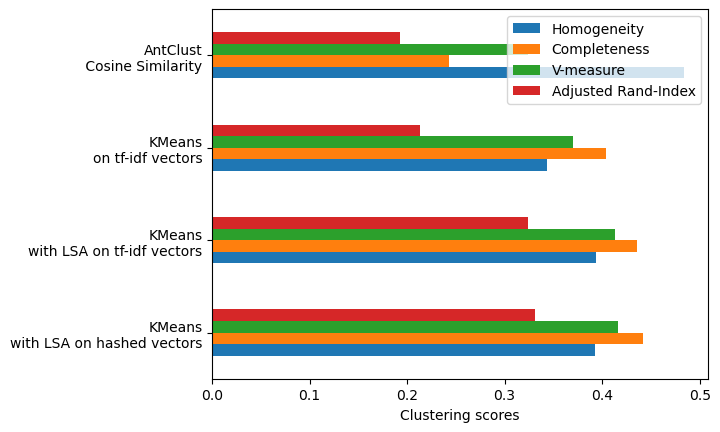

In [51]:
df.drop(
    ["train_time", "Silhouette Coefficient"],
    axis="columns",
).plot.barh()
plt.xlabel("Clustering scores")
plt.ylabel("")
plt.show()

In [52]:
df 

,train_time,Homogeneity,Completeness,V-measure,Adjusted Rand-Index,Silhouette Coefficient
KMeans\nwith LSA on hashed vectors,0.111114,0.392749,0.441747,0.415805,0.330707,0.030190
KMeans\nwith LSA on tf-idf vectors,0.086680,0.393501,0.435161,0.413194,0.323662,0.031571
KMeans\non tf-idf vectors,6.402485,0.343134,0.404380,0.370404,0.212785,0.007766
AntClust\n Cosine Similarity,730.867769,0.484350,0.242738,0.323400,0.192821,NaN
